In [2]:
import os
route = os.getcwd() + "\\" + "Public_Data" + "\\"

In [2]:
place = input("찾으실 지역의 이름을 적으세요 : ")

찾으실 지역의 이름을 적으세요 : 대구


In [3]:
import folium
import json
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 10000)

# 데이터 불러오기

In [4]:
sub = pd.read_csv(route + "전국 지하철.csv",encoding='UTF8')

In [5]:
office = pd.read_csv(route + place + " 관공서.csv",encoding='UTF8')
market = pd.read_csv(route + place + " 마켓.csv",encoding='UTF8')
tour = pd.read_csv(route + place + " 명소.csv",encoding='UTF8')
hospital = pd.read_csv(route + place + " 병원.csv",encoding='UTF8')
cafe = pd.read_csv(route + place + " 카페.csv",encoding='UTF8')
terminal = pd.read_csv(route + place + " 터미널.csv",encoding='UTF8')
fastfood = pd.read_csv(route + place + " 패스트푸드.csv",encoding='UTF8')
school = pd.read_csv(route + place + " 학교.csv",encoding='UTF8')
shopping = pd.read_csv(route + place + " 쇼핑.csv",encoding='UTF8')
cinema = pd.read_csv(route + place + " 영화관.csv",encoding='UTF8')

In [6]:
population = pd.read_csv(route + "인구.csv", encoding='cp949')

인구 변경

In [7]:
population = population[['행정구역','2019년10월_계_연령구간인구수']]
population.columns=['행정구역','total']

In [8]:
population = population[population['행정구역'].str.startswith(pat=place)]
population = population.drop(population[population['행정구역'].str.endswith(pat='00000)')].index)

In [9]:
population['행정구역']=population['행정구역'].str.split('(',n=2,expand=True)
population['total']=population['total'].str.replace(pat=',',repl='',regex=False)
population[['si','gu','dong']]=population['행정구역'].str.split(' ',n=3,expand=True)

In [10]:
cols=population.columns.tolist()
cols=cols[-1:]+cols[:-1]
population=population[cols]
population=population.reset_index(drop=True)

통합

In [11]:
data = pd.concat([office,market,tour,hospital,cafe,terminal,fastfood,school,shopping,cinema])
#data = pd.concat([office, market, cafe, terminal, fastfood, shopping, cinema])
data=data.reset_index(drop=True)


Geojson(대구&동)

In [12]:
rfile = open(route + 'HangJeongDong_ver20190908.geojson','r',encoding='utf-8').read()
df = gpd.read_file(rfile)

In [13]:
city = df[df['adm_nm'].str.startswith(pat='대구광역시')]
city = city[city['OBJECTID']<757]#대구 행정코드
city=city.reset_index(drop=True)

In [14]:
dong = pd.DataFrame(columns=['si','gu','dong'],index=np.arange(len(city)))

In [15]:
dong[['si','gu','dong']] = city['adm_nm'].str.split(' ',n=3,expand=True)

In [16]:
dong['dong']=dong['dong'].str.replace(pat='·',repl='.',regex=False)
dong['dong']=dong['dong'].str.replace(pat=',',repl='.',regex=False)

In [17]:
del dong['si']
del dong['gu']

In [18]:
donglist = dong['dong']

좌표

sub=sub[sub['노선명'].str.startswith(pat='대구')]
sub=sub[['역사명','역사도로명주소']]
sub.columns=['name','address']
sub=sub.reset_index(drop=True)

headers = {'Authorization' : 'KakaoAK '}
k=0
for i in sub['address']:
    body = {'query':i}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)
    res = json.loads(response.text)
    if(res['documents']!=[]):
        sub.loc[k,'lat']=res['documents'][0]['y']
        sub.loc[k,'long']=res['documents'][0]['x']
        sub.loc[k,'dong']=res['documents'][0]['address']['region_3depth_h_name']
    k = k + 1

headers = {'Authorization' : 'KakaoAK '}
k = 0
for i in data['address']:
    body = {'query':i}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)
    res = json.loads(response.text)
    if(res['documents']!=[]):
        try:
            data.loc[k,'lat']=res['documents'][0]['y']
            data.loc[k,'long']=res['documents'][0]['x']
            data.loc[k,'dong']=res['documents'][0]['address']['region_3depth_h_name']
        except:
            continue
    k = k + 1

sub = sub[['name','lat','long','dong']]
data = data[['name','lat','long','dong']]

data = data.dropna()
data = data[data.dong!='']
data = data.reset_index(drop=True)

없는동 데이터 삭제

new = pd.DataFrame(columns=['name','lat','long','dong'])

k=0
for x in range(len(data)):
    flag =True
    for y in donglist:
        if data.loc[x,'dong']==y:
            flag=False
    if flag ==False:
        new.loc[k]=data.loc[x]
        k+=1

지하철 500m 데이터 삭제

from math import radians, cos, sin, asin, sqrt
def haversine(lon1,lat1,lon2,lat2):
    lon1,lat1,lon2,lat2 = map(radians,[lon1,lat1,lon2,lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c=2*asin(sqrt(a))
    km=6371*c
    return km   

for i in range(len(new)):
    for j in range(len(sub)):
        if haversine(float(new.loc[i,'long']),float(new.loc[i,'lat']),float(sub.loc[j,'long']),float(sub.loc[j,'lat']))<1.0:
            new=new.drop(i)
            break

new=new.reset_index(drop=True)

new.to_pickle(route + "data_file.pkl")  # where to save it, usually as a .pkl

sub.to_pickle(route + "sub_file.pkl")

new안에 모든 데이터 다들어가있음
lat이 35, long이 128

인구,데이터,지하철 분석

In [4]:
import pandas as pd
data = pd.read_pickle(route + 'data_file.pkl')
sub = pd.read_pickle(route + "sub_file.pkl")

In [20]:
data_num=data['dong'].value_counts()
sub_num=sub['dong'].value_counts()

In [21]:
for x in range(len(dong)):
    for y in range(len(population)):
        if dong.loc[x,'dong']==population.loc[y,'dong']:
            dong.loc[x,'pop']=population.loc[y,'total']
    for z in range(len(data_num)):
        if dong.loc[x,'dong']==data_num.index[z]:
            dong.loc[x,'data']=data_num[z]
    for w in range(len(sub_num)):
        if dong.loc[x,'dong']==sub_num.index[w]:
            dong.loc[x,'sub']=sub_num[w]

In [22]:
dong=dong.fillna(0)

In [23]:
dong['pop']=dong['pop'].astype(float)

In [24]:
mp=dong['pop'].mean()
md=dong['data'].mean()

In [25]:
for x in range(len(dong)):
    dong.loc[x,'corr'] = (dong.loc[x,'pop']-mp)*(dong.loc[x,'data']-md)

In [26]:
pmdm=dong[dong['sub']<=1][dong['corr']>0][dong['pop']>mp][dong['data']>md].sort_values(by='corr', ascending = False)
pldl=dong[dong['sub']<=1][dong['corr']>0][dong['pop']<mp][dong['data']<md].sort_values(by='corr', ascending = False)
pmdl=dong[dong['sub']<=1][dong['corr']<0][dong['pop']>mp][dong['data']<md].sort_values(by='corr', ascending = True)
pldm=dong[dong['sub']<=1][dong['corr']<0][dong['pop']<mp][dong['data']>md].sort_values(by='corr', ascending = True)

clustering

In [27]:
output = [[ 0 for x in range(2) ] for y in range(len(data))]

for i in range(0, len(data)):
    output[i][1] = data['lat'][i] #y
    output[i][0] = data['long'][i] #x

In [28]:
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

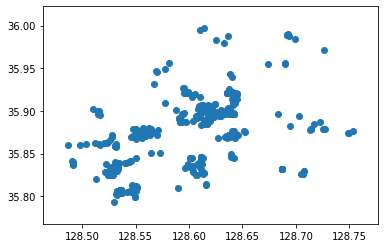

In [29]:
X, y = make_blobs(n_samples=len(output), centers=1, cluster_std=0.60, random_state=0)

for i in range(0, len(output)-1): 
    X[i, 1] = output[i+1][1]
    X[i, 0] = output[i+1][0]

    
X[len(output)-1, 0] = output[i][0]
X[len(output)-1, 1] = output[i][1]
plt.scatter(X[:,0], X[:,1])

folium

In [30]:
from folium import plugins
X_coords = []

for i in range(len(X)):
    X_coords.append([X[i, 1], X[i, 0]])

map_result_str = folium.Map(location = [35.8649035,128.5823176], zoom_start = 11)
popups = [str(i) for i in range(len(X_coords))]
plugins.MarkerCluster(X_coords, popups=popups).add_to(map_result_str)
map_result_str

In [31]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
dbscan = DBSCAN(eps=0.008, min_samples = 10)
clusters = dbscan.fit_predict(X)


C:\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


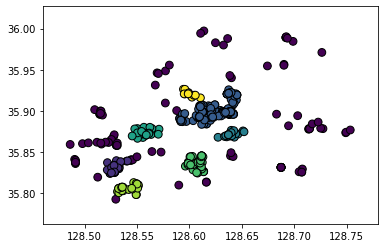

In [32]:
import mglearn

plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', s=60, edgecolors='black')
plt.show()

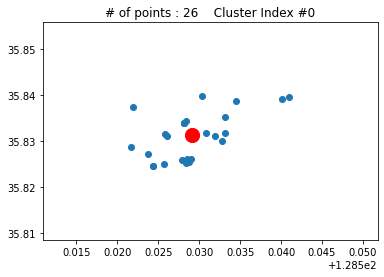

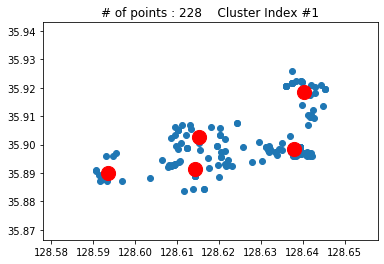

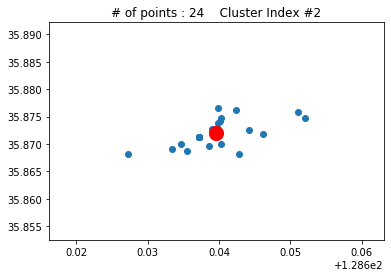

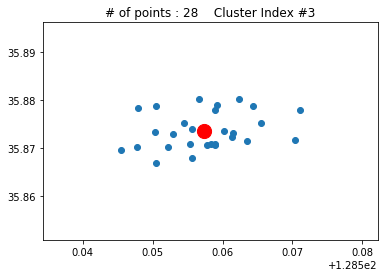

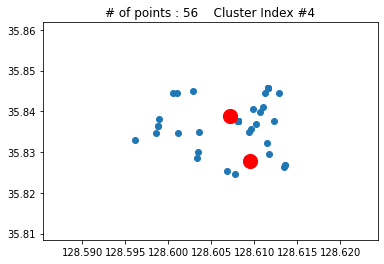

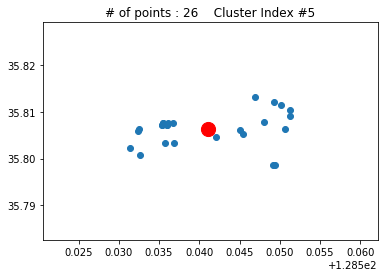

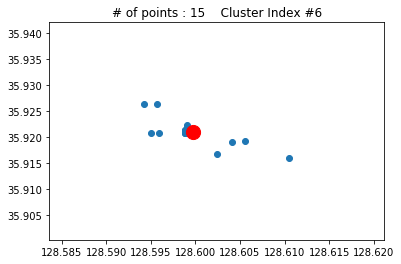

In [33]:
cluster_data = [[[0.0 for row in range(2)] for col in range(1)] for cnum in range(np.max(clusters) + 1) ]
cluster_num = 1
cluster_center = [[0.0 for row in range(2)] for col in range(1)]

for j in range(np.max(clusters) + 1):
    count = 0
    for i in range(len(clusters)):
        if clusters[i] == j:
            count = count + 1
            if count == 1:
                cluster_data[j][0][0] = X[i, 0]
                cluster_data[j][0][1] = X[i, 1]
            else:
                cluster_data[j].append([X[i,0], X[i, 1]])
    print()        
    cluster_data_array = np.array(cluster_data[j])

    if int(count / 50) == 0:
        cluster_num = 1
    else:
        cluster_num = int(count / 50) + 1

    kmeans = KMeans(n_clusters=cluster_num, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict(cluster_data_array)
    plt.scatter(cluster_data_array[:,0], cluster_data_array[:,1])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
    
    for k in range(len(kmeans.cluster_centers_)):
        if k == 0 and j == 0:
            cluster_center[0][0] = kmeans.cluster_centers_[k, 0]
            cluster_center[0][1] = kmeans.cluster_centers_[k, 1]
        else:
            cluster_center.append([kmeans.cluster_centers_[k,0], kmeans.cluster_centers_[k, 1]])
    plt.title("# of points : " + str(count) + "    Cluster Index #" + str(j))
    plt.show()

In [34]:
final_x = []
final_y = []

for i in range(len(cluster_center)):
    final_x.append(cluster_center[i][0])
    final_y.append(cluster_center[i][1])

map

In [35]:
map_result_all = folium.Map(location = [35.8649035,128.5823176], zoom_start = 10)

In [36]:
map_result_final = folium.Map(location = [35.8649035,128.5823176], zoom_start = 10)

In [37]:
headers = {'Authorization' : 'KakaoAK '}

for i in range(10):
    location = pmdm['dong'].iloc[i]
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']

    folium.CircleMarker([y, x], color = 'blue', radius = 2).add_to(map_result_all)

In [38]:
headers = {'Authorization' : 'KakaoAK '}

for i in range(10):
    location = pldl['dong'].iloc[i]
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']
    folium.CircleMarker([y, x], color = 'green', radius = 2).add_to(map_result_all)
        
    final_x.append(x)
    final_y.append(y)
    folium.CircleMarker([y, x], color = 'green', radius = 2).add_to(map_result_final)

In [39]:
headers = {'Authorization' : 'KakaoAK '}

for i in range(10):
    location = pmdl['dong'].iloc[i]
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']
    folium.CircleMarker([y, x], color = 'yellow', radius = 2).add_to(map_result_all)
    
    final_x.append(x)
    final_y.append(y)
    
    folium.CircleMarker([y, x], color = 'yellow', radius = 2).add_to(map_result_final)

In [40]:
headers = {'Authorization' : 'KakaoAK '}

for i in range(10):
    location = pldm['dong'].iloc[i]
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']
    folium.CircleMarker([y, x], color = 'black', radius = 2).add_to(map_result_all)

In [41]:
for i in range(0, len(cluster_center)):
    folium.CircleMarker([np.array(cluster_center)[i, 1], np.array(cluster_center)[i, 0]], color = 'red', radius = 5).add_to(map_result_all)
    folium.CircleMarker([np.array(cluster_center)[i, 1], np.array(cluster_center)[i, 0]], color = 'red', radius = 5).add_to(map_result_final)

In [42]:
map_result_all

In [43]:
final_matrix = [[0]*len(final_x) for i in range(len(final_y))]

In [44]:
import math
for i in range(len(final_x)):
    x_start = final_x[i]
    y_start = final_y[i]
    for j in range(len(final_x)):
        x_end = final_x[j]
        y_end = final_y[j]
        final_matrix[i][j] = math.sqrt( (
            float(x_start) - float(x_end)) **2 + (float(y_start) - float(y_end)) **2 )

In [45]:
import heapq

class PriorityQueue():
    def __init__(self):
        self.queue = []
        self.count = 0
    
    def clear(self):
        self.queue = []
        self.count = 0
    
    def enqueue(self, priority, u, v):
        self.count += 1
        heapq.heappush(self.queue, (priority, u, v))
        
    def dequeue(self):
        if self.count <= 0:
            return None
        self.count -= 1
        dist, u, v = heapq.heappop(self.queue)
        return u, v
        
    def display(self):
        print(self.queue)

graph = []
flag = []
path = []

def nearest_neighbor(u):
    global flag
    pq = PriorityQueue()
    flag[u] = True
    
    while False in flag:
        near = graph[u]
        for v in range(len(near)):
            if flag[v] is False and near[v] > 0:
                pq.enqueue(near[v], u, v)
        
        u, v = pq.dequeue()
        path.append((u, v))
        flag[v] = True
        u = v
        pq.clear()

def findpath(g, start):
    global graph
    global flag 
    
    graph = g
    flag = [False for _ in range(len(graph[0]))]
    nearest_neighbor(start)

In [46]:
findpath(final_matrix, 2)

In [47]:
for i in range(len(path)):
    folium.PolyLine([ [ float(final_y[path[i][0]]) , float(final_x[path[i][0]]) ], [ float(final_y[path[i][1]]), float(final_x[path[i][1]]) ] ], weight=2, opacity=1, color="black").add_to(map_result_final)

In [48]:
map_result_final

In [49]:
need = input("지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) ")
num = input("시작점을 적으세요 ")
between_length = input("주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) ")
between_length = float(between_length)

map_result_final = folium.Map(location = [35.8649035,128.5823176], zoom_start = 10)
temp_x = []
temp_y = []

final_x = []
final_y = []

pldl_x = []
pldl_y = []

pmdl_x = []
pmdl_y = []


for i in range(len(cluster_center)):
    final_x.append(cluster_center[i][0])
    final_y.append(cluster_center[i][1])

from math import radians, cos, sin, asin, sqrt

def haversine(lon1,lat1,lon2,lat2):
    lon1,lat1,lon2,lat2 = map(radians,[lon1,lat1,lon2,lat2])
    dlon = lon2-lon1
    dlat = lat2-lat1
    a=sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    c=2*asin(sqrt(a))
    km=6371*c
    return km

#인구는 많은데 상가는 적은 지역 (시안)
headers = {'Authorization' : 'KakaoAK '}
num_pmdl = int((int(need) - len(cluster_center)) / 2)
i_pmdl = 0

while(True):
    if (i_pmdl == num_pmdl or i_pmdl == len(pmdl)) : break

    location = pmdl['dong'].iloc[i_pmdl]
    i_pmdl += 1
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']
    
    for j in range(len(cluster_center)):
        len_pmdl = haversine(float(x), float(y), float(cluster_center[j][0]), float(cluster_center[j][1]))
        if (len_pmdl < between_length) :
            error_sign = 0
            while(True) :
                if (len(temp_x) == 0) :
                    temp_x.append(x)
                    temp_y.append(y)
                    
                    pmdl_x.append(x)
                    pmdl_y.append(y)
                    break
                    
                else :
                    for m in range(len(temp_x)):
                        len_temp = haversine(float(x), float(y), float(temp_x[m]), float(temp_y[m]))
                        if (len_temp < between_length) : 
                            error_sign = 1
                    if (error_sign == 0) :
                        temp_x.append(x)
                        temp_y.append(y)
                        pmdl_x.append(x)
                        pmdl_y.append(y)
                    break
                    
for k in range(len(pmdl_x)):
    folium.CircleMarker([pmdl_y[k], pmdl_x[k]], color = 'cyan', radius = 4).add_to(map_result_final)

             
# 인구도 적고, 상가도 적은 지역 (파랑)
num_pldl = int((int(need) - len(cluster_center)) / 2)
i_pldl = 0

while(True):
    if (i_pldl == num_pldl or i_pldl == len(pmdl)) : break

    location = pldl['dong'].iloc[i_pldl]
    i_pldl += 1
    body = {'query' : place + " " + location}
    response = requests.request("GET",
                            'https://dapi.kakao.com/v2/local/search/address.json',
                            data=body,
                            headers=headers)

    res = json.loads(response.text)

    x = res['documents'][0]['x']
    y = res['documents'][0]['y']
    
    for j in range(len(cluster_center)):
        len_pldl = haversine(float(x), float(y), float(cluster_center[j][0]), float(cluster_center[j][1]))
        if (len_pldl < between_length) :
            error_sign = 0
            while(True) :
                if (len(temp_x) == 0) :
                    temp_x.append(x)
                    temp_y.append(y)
                    pldl_x.append(x)
                    pldl_y.append(y)
                    break
                    
                else :
                    for m in range(len(temp_x)):
                        len_temp = haversine(float(x), float(y), float(temp_x[m]), float(temp_y[m]))
                        if (len_temp < between_length) : 
                            error_sign = 1
                    if (error_sign == 0) :
                        temp_x.append(x)
                        temp_y.append(y)
                        pldl_x.append(x)
                        pldl_y.append(y)
                    break
                    
for k in range(len(pldl_x)):
    folium.CircleMarker([pldl_y[k], pldl_x[k]], color = 'blue', radius = 4).add_to(map_result_final)
    
for i in range(0, len(cluster_center)):
    folium.CircleMarker([np.array(cluster_center)[i, 1], np.array(cluster_center)[i, 0]], color = 'red', radius = 5).add_to(map_result_final)

final_x = final_x + pldl_x + pmdl_x
final_y = final_y + pldl_y + pmdl_y

final_matrix = [[0]*len(final_x) for i in range(len(final_y))]
import math
for i in range(len(final_x)):
    x_start = final_x[i]
    y_start = final_y[i]
    for j in range(len(final_x)):
        x_end = final_x[j]
        y_end = final_y[j]
        final_matrix[i][j] = math.sqrt( (
            float(x_start) - float(x_end)) **2 + (float(y_start) - float(y_end)) **2 )
        
import heapq

class PriorityQueue():
    def __init__(self):
        self.queue = []
        self.count = 0
    
    def clear(self):
        self.queue = []
        self.count = 0
    
    def enqueue(self, priority, u, v):
        self.count += 1
        heapq.heappush(self.queue, (priority, u, v))
        
    def dequeue(self):
        if self.count <= 0:
            return None
        self.count -= 1
        dist, u, v = heapq.heappop(self.queue)
        return u, v
        
    def display(self):
        print(self.queue)

graph = []
flag = []
path = []

def nearest_neighbor(u):
    global flag
    pq = PriorityQueue()
    flag[u] = True
    
    while False in flag:
        near = graph[u]
        for v in range(len(near)):
            if flag[v] is False and near[v] > 0:
                pq.enqueue(near[v], u, v)
        
        u, v = pq.dequeue()
        path.append((u, v))
        flag[v] = True
        u = v
        pq.clear()

def findpath(g, start):
    global graph
    global flag 
    
    graph = g
    flag = [False for _ in range(len(graph[0]))]
    nearest_neighbor(start)
findpath(final_matrix, int(num))

for i in range(0, len(path)):
    folium.PolyLine([ [ float(final_y[path[i][0]]) , float(final_x[path[i][0]]) ], [ float(final_y[path[i][1]]), float(final_x[path[i][1]]) ] ], weight=2, opacity=1, color="black").add_to(map_result_final)

folium.PolyLine([ [ float(final_y[path[i][1]]), float(final_x[path[i][1]])], [ float(final_y[path[0][0]]), float(final_x[path[0][0]])] ], weight=2, opacity=1, color="black").add_to(map_result_final)

for i in range(len(X)):
    folium.CircleMarker([X[i, 1], X[i, 0]], color = 'green', radius = 0.3).add_to(map_result_final)
map_result_final

#20 4 2

지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) 20
시작점을 적으세요 4
주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) 2


In [50]:
curve_y = []
curve_x = []

for i in range(0, len(path)):
    curve_y.append(float(final_y[path[i][0]]))
    curve_x.append(float(final_x[path[i][0]]))

curve_y.append(float(final_y[path[i][1]]))
curve_x.append(float(final_x[path[i][1]]))
curve_y.append(float(final_y[path[0][0]]))
curve_x.append(float(final_x[path[0][0]]))

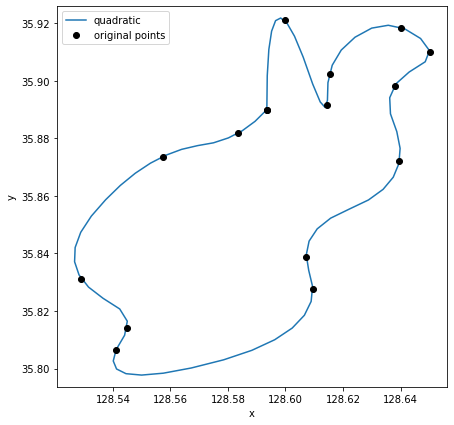

In [51]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Define some points:
points = np.array([curve_x, curve_y]).T  # a (nbre_points x nbre_dim) array

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
#interpolations_methods = ['slinear', 'quadratic', 'cubic']
interpolations_methods = ['quadratic']
alpha = np.linspace(0, 1, 75)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);

plt.plot(*points.T, 'ok', label='original points');
plt.axis('equal'); 
plt.legend(); 
plt.xlabel('x'); 
plt.ylabel('y');

In [52]:
map_result_curve = folium.Map(location = [35.8649035,128.5823176], zoom_start = 10)

for i in range(len(points)):
    folium.CircleMarker([points[i, 1], points[i, 0]], color = 'red', radius = 2).add_to(map_result_curve)

for i in range(len(curve) - 1):
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], weight=2, opacity=1, color="black").add_to(map_result_curve)

map_result_curve

In [53]:
bus = pd.read_csv(route + place + " 버스정류장.csv", encoding='cp949')

In [54]:
bus_output = [[0 for x in range(2)] for y in range(len(bus))]

for i in range(0, len(bus)):
    bus_output[i][1] = bus['lat'][i]
    bus_output[i][0] = bus['lon'][i]

In [55]:
len(bus_output)

1098

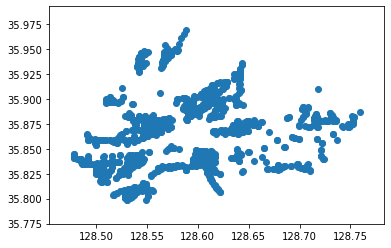

In [56]:
bus_X, bus_y = make_blobs(n_samples=len(bus_output), centers=1, cluster_std=0.60, random_state=0)

for i in range(0, len(bus_output)-1): 
    bus_X[i, 1] = bus_output[i+1][1]
    bus_X[i, 0] = bus_output[i+1][0]

    
bus_X[len(bus_output)-1, 0] = bus_output[i][0]
bus_X[len(bus_output)-1, 1] = bus_output[i][1]
plt.scatter(bus_X[:,0], bus_X[:,1])

In [57]:
from folium import plugins
bus_X_coords = []

for i in range(len(bus_X)):
    bus_X_coords.append([bus_X[i, 1], bus_X[i, 0]])

bus_map_result_str = folium.Map(location = [35.8649035,128.5823176], zoom_start = 11)
popups = [str(i) for i in range(len(bus_X_coords))]
plugins.MarkerCluster(bus_X_coords, popups=popups).add_to(bus_map_result_str)

bus_map_result_str.save("only_bus_map.html")
bus_map_result_str

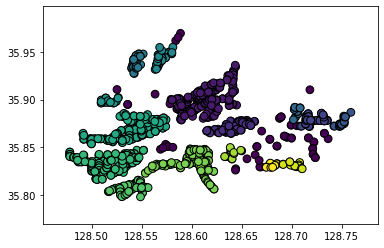

In [58]:
bus_dbscan = DBSCAN(eps=0.008, min_samples = 10)
bus_clusters = bus_dbscan.fit_predict(bus_X)
plt.scatter(bus_X[:, 0], bus_X[:, 1], c=bus_clusters, cmap='viridis', s=60, edgecolors='black')
plt.show()
#00.8 10

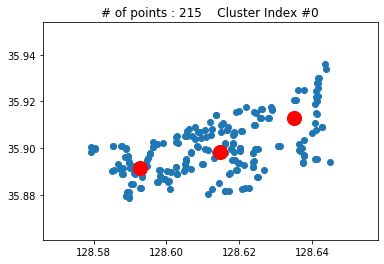

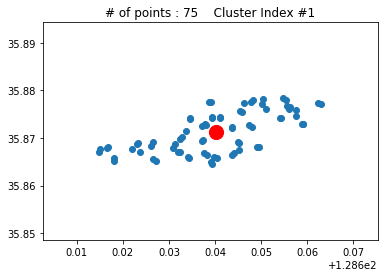

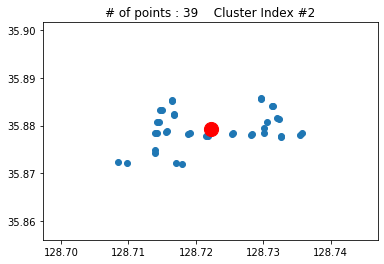

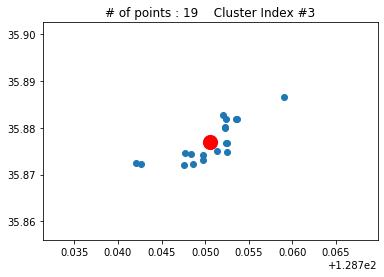

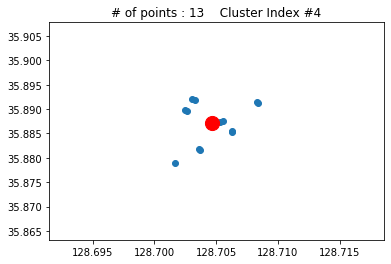

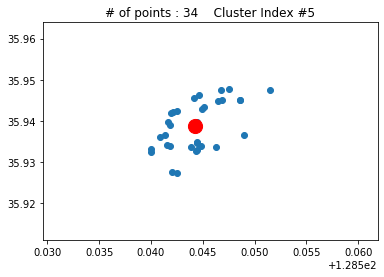

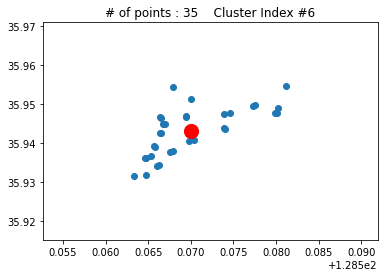

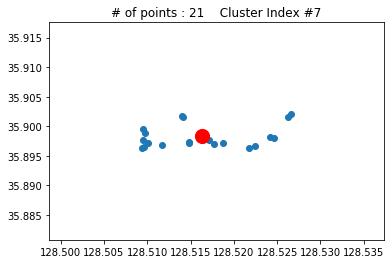

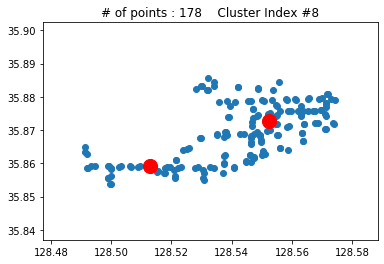

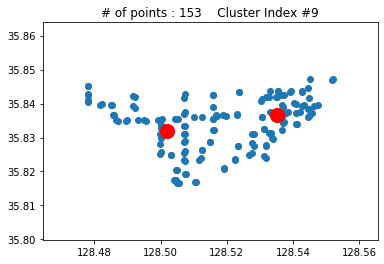

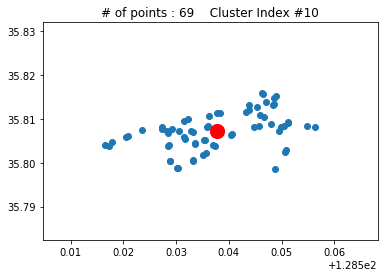

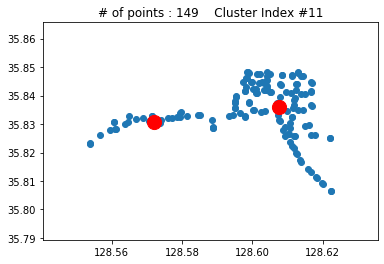

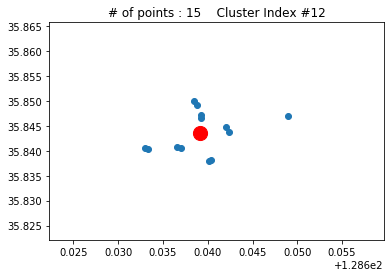

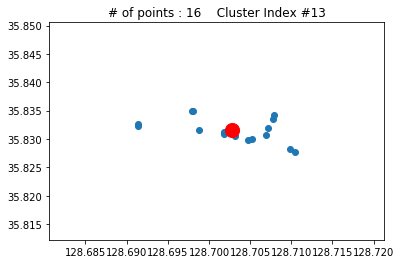

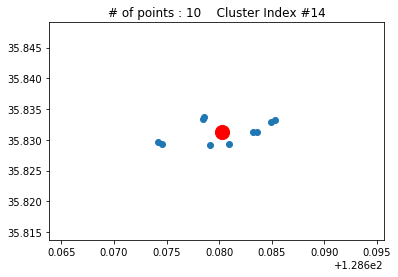

In [59]:
bus_cluster_data = [[[0.0 for row in range(2)] for col in range(1)] for cnum in range(np.max(bus_clusters) + 1) ]
bus_cluster_num = 1
bus_cluster_center = [[0.0 for row in range(2)] for col in range(1)]
bus_cluster_standard = 100

bus_reason_x = []
bus_reason_y = []

for j in range(np.max(bus_clusters) + 1):
    bus_count = 0
    for i in range(len(bus_clusters)):
        if bus_clusters[i] == j:
            bus_count = bus_count + 1
            if bus_count == 1:
                bus_cluster_data[j][0][0] = bus_X[i, 0]
                bus_cluster_data[j][0][1] = bus_X[i, 1]
            else:
                bus_cluster_data[j].append([bus_X[i,0], bus_X[i, 1]])
    print()        
    bus_cluster_data_array = np.array(bus_cluster_data[j])

    if int(bus_count / bus_cluster_standard) == 0:
        bus_cluster_num = 1
    else:
        bus_cluster_num = int(bus_count / bus_cluster_standard) + 1

    bus_kmeans = KMeans(n_clusters=bus_cluster_num, init='k-means++', max_iter=300, n_init=10, random_state=0)
    bus_pred_y = bus_kmeans.fit_predict(bus_cluster_data_array)
    plt.scatter(bus_cluster_data_array[:,0], bus_cluster_data_array[:,1])
    
    bus_reason_x.append(bus_cluster_data_array[:,0])
    bus_reason_y.append(bus_cluster_data_array[:,1])
    
    plt.scatter(bus_kmeans.cluster_centers_[:, 0], bus_kmeans.cluster_centers_[:, 1], s=200, c='red')
    
    for k in range(len(bus_kmeans.cluster_centers_)):
        if k == 0 and j == 0:
            bus_cluster_center[0][0] = bus_kmeans.cluster_centers_[k, 0]
            bus_cluster_center[0][1] = bus_kmeans.cluster_centers_[k, 1]
        else:
            bus_cluster_center.append([bus_kmeans.cluster_centers_[k,0], bus_kmeans.cluster_centers_[k, 1]])
    plt.title("# of points : " + str(bus_count) + "    Cluster Index #" + str(j))
    plt.show()

    #100

In [60]:
bus_x = []
bus_y = []

for i in range(len(bus_cluster_center)):
    bus_x.append(bus_cluster_center[i][0])
    bus_y.append(bus_cluster_center[i][1])

In [61]:
map_result_bus = folium.Map(location = [35.8649035,128.5823176], zoom_start = 11)

bus_location_x = []
bus_location_y = []

for i in range(len(bus_cluster_center)):
    bus_location_y.append(bus_cluster_center[i][1])
    bus_location_x.append(bus_cluster_center[i][0])

for i in range(len(bus_reason_x)):
    for j in range(len(bus_reason_x[i])):
        folium.CircleMarker([np.array(bus_reason_y)[i][j], np.array(bus_reason_x)[i][j]], color = '#AC58FA', radius = 0.3, fill_color= "#AC58FA", fill_opacity = 1).add_to(map_result_bus)

for i in range(0, len(bus_location_x)):
    folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#6A0888', radius = 5, fill_color= "#6A0888", fill_opacity = 1).add_to(map_result_bus)

for i in range(0, len(bus_location_x)):
    if (bus_location_y[i] > 35.808 and bus_location_y[i] <35.898 and bus_location_x[i] < 128.65):
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#FE2E2E', radius = 5, fill_color= "#FE2E2E", fill_opacity = 1).add_to(map_result_bus)

    if (bus_location_y[i] == 35.89845984659498):
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#FE2E2E', radius = 5, fill_color= "#FE2E2E", fill_opacity = 1).add_to(map_result_bus)
    
map_result_bus.save("bus_map.html")
map_result_bus
#버스 클러스터링 좌표 표현 지도

In [62]:
bus_location_y

[35.89845984659498,
 35.89162002536232,
 35.9130001591195,
 35.87127352644445,
 35.87932414145299,
 35.877042517543856,
 35.887221279487186,
 35.93875204803921,
 35.94319724142857,
 35.89830007460318,
 35.859105152941176,
 35.87276605879265,
 35.83652579009009,
 35.83191979957806,
 35.807193635024156,
 35.83059647311828,
 35.83585549646892,
 35.843618927777776,
 35.831594540625,
 35.83132033333334]

In [63]:
map_result_bus = folium.Map(location = [35.8649035,128.5823176], zoom_start = 10)

bus_location_x = []
bus_location_y = []

for i in range(len(bus_cluster_center)):
    if (bus_cluster_center[i][1] > 35.808 and bus_cluster_center[i][1] <35.897 and bus_cluster_center[i][0] < 128.65):
        bus_location_y.append(bus_cluster_center[i][1])
        bus_location_x.append(bus_cluster_center[i][0])

for i in range(0, len(bus_location_x)):
    folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#6A0888', radius = 11, fill_color= "#6A0888", fill_opacity = 1).add_to(map_result_bus)

map_result_bus.save("bus_filter_map.html")
map_result_bus

#버스 클러스터링 좌표 표현 지도

In [64]:
for i in range(len(bus_location_x)):
    folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 3, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_final)
map_result_final
        
#35.9 128.65

In [65]:
final_x = final_x + bus_location_x
final_y = final_y + bus_location_y

In [66]:
last_x = []
last_y = []

for i in range(len(final_x)):
    if (i != 11 and i != 10 and i != 8 and i != 19): #너무 돌아가기 때문에 제외
        last_x.append(final_x[i])
        last_y.append(final_y[i])

final_x = last_x
final_y = last_y


In [67]:
map_result_before = folium.Map(location = [35.8049035,128.5823176], zoom_start = 11)
# 카페 데이터 : 빨강
for i in range(len(last_y)):
    folium.CircleMarker([last_y[i], last_x[i]], color = '#red', radius = 5, fill_color= "red", fill_opacity = 1).add_to(map_result_before)

# 버스 데이터 : 보라
for i in range(len(bus_location_y)):
    if (i != 4): # 본동 제거
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 5, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_before)

# 사람적고 카페적음 : 파랑
for i in range(len(pldl_y)):
    folium.CircleMarker([pldl_y[i], pldl_x[i]], color = 'blue', radius = 5, fill_color= "blue", fill_opacity = 1).add_to(map_result_before)

# 사람많고 카페적음 : 시안
for i in range(len(pmdl_y)):
    folium.CircleMarker([pmdl_y[i], pmdl_x[i]], color = 'cyan', radius = 5, fill_color= "cyan", fill_opacity = 1).add_to(map_result_before)

    
before_y = []
before_x = []

before_y = last_y + bus_location_y + pmdl_y + pldl_y
before_x = last_x + bus_location_x + pmdl_x + pldl_x

sub1 = pd.read_pickle(route + "sub1.pkl")
sub2 = pd.read_pickle(route + "sub2.pkl")
sub3 = pd.read_pickle(route + "sub3.pkl")

sub1.sort_values(by=['long'], axis = 0)
sub2.sort_values(by=['long'], axis = 0)
sub3.sort_values(by=['lat'], axis = 0)

for i in range(0, len(sub1) - 1):
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_before)
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color='#446AE8', weight=3, opacity=1, offset = 0).add_to(map_result_before)

for i in range(len(sub1), len(sub1) + len(sub2) - 1):
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_before)
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color='#F781D8', weight=3, opacity=1, offset = 0).add_to(map_result_before)
    
for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3) - 1):
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_before)
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color='#B43104', weight=3, opacity=1, offset = 0).add_to(map_result_before)

for i in range(len(sub1)):
    folium.CircleMarker([sub1['lat'][i], sub1['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_before)

for i in range(len(sub1), len(sub1)+len(sub2)):
    folium.CircleMarker([sub2['lat'][i], sub2['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_before)

for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3)):
    folium.CircleMarker([sub3['lat'][i], sub3['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_before)

    
need = input("지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) ")
num = input("시작점을 적으세요 ")
between_length = input("주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) ")
between_length = float(between_length)

before_matrix = [[0]*len(before_x) for i in range(len(before_y))]

import math
for i in range(len(before_x)):
    x_start = before_x[i]
    y_start = before_y[i]
    for j in range(len(before_x)):
        x_end = before_x[j]
        y_end = before_y[j]
        before_matrix[i][j] = math.sqrt( (
            float(x_start) - float(x_end)) **2 + (float(y_start) - float(y_end)) **2 )
        
import heapq

class PriorityQueue():
    def __init__(self):
        self.queue = []
        self.count = 0
    
    def clear(self):
        self.queue = []
        self.count = 0
    
    def enqueue(self, priority, u, v):
        self.count += 1
        heapq.heappush(self.queue, (priority, u, v))
        
    def dequeue(self):
        if self.count <= 0:
            return None
        self.count -= 1
        dist, u, v = heapq.heappop(self.queue)
        return u, v
        
    def display(self):
        print(self.queue)

graph = []
flag = []
path = []

def nearest_neighbor(u):
    global flag
    pq = PriorityQueue()
    flag[u] = True
    
    while False in flag:
        near = graph[u]
        for v in range(len(near)):
            if flag[v] is False and near[v] > 0:
                pq.enqueue(near[v], u, v)
        
        u, v = pq.dequeue()
        path.append((u, v))
        flag[v] = True
        u = v
        pq.clear()

def findpath(g, start):
    global graph
    global flag 
    
    graph = g
    flag = [False for _ in range(len(graph[0]))]
    nearest_neighbor(start)
findpath(before_matrix, int(num))

for i in range(0, len(path)):
    folium.PolyLine([ [ float(before_y[path[i][0]]) , float(before_x[path[i][0]]) ], [ float(before_y[path[i][1]]), float(before_x[path[i][1]]) ] ], weight=2, opacity=1, color="black").add_to(map_result_before)

folium.PolyLine([ [ float(before_y[path[i][1]]), float(before_x[path[i][1]])], [ float(before_y[path[0][0]]), float(before_x[path[0][0]])] ], weight=2, opacity=1, color="black").add_to(map_result_before)

map_result_before.save("4호선 변경전.html")
map_result_before

#44 / 21 / 2

지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) 44
시작점을 적으세요 21
주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) 2


# 환승역으로 좌표 이동

In [68]:
final_x[6]=128.6320821467215
final_y[6]=35.88423738126278


#북구청
final_x[9]=128.58136532434435
final_y[9]=35.8839823857188
pldl_x[0] = 128.58136532434435
pldl_y[0] = 35.8839823857188

In [69]:
change = [[128.64537117227238,35.85880260568121],
         [128.62429705227785,35.83918861377069],
         [128.5072530388312,35.851729704038334],
         [128.5378968469256,35.81895379031608]]

In [70]:
for x in change:
    final_x.append(x[0])
    final_y.append(x[1])

In [71]:
final_matrix = [[0]*len(final_x) for i in range(len(final_y))]

In [72]:
map_result_last = folium.Map(location = [35.8049035,128.5823176], zoom_start = 11)

# 카페 데이터 : 빨강
for i in range(len(last_y)):
    folium.CircleMarker([last_y[i], last_x[i]], color = '#red', radius = 5, fill_color= "red", fill_opacity = 1).add_to(map_result_last)

# 버스 데이터 : 보라
for i in range(len(bus_location_y)):
    if (i != 4): # 본동 제거
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 5, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_last)

# 사람적고 카페적음 : 파랑
for i in range(len(pldl_y)):
    folium.CircleMarker([pldl_y[i], pldl_x[i]], color = 'blue', radius = 5, fill_color= "blue", fill_opacity = 1).add_to(map_result_last)

# 사람많고 카페적음 : 시안
for i in range(len(pmdl_y)):
    folium.CircleMarker([pmdl_y[i], pmdl_x[i]], color = 'cyan', radius = 5, fill_color= "cyan", fill_opacity = 1).add_to(map_result_last)
        

final_x = final_x + bus_location_x
final_y = final_y + bus_location_y

final_matrix = [[0]*len(final_x) for i in range(len(final_y))]

In [73]:
need = input("지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) ")
num = input("시작점을 적으세요 ")
between_length = input("주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) ")
between_length = float(between_length)

final_matrix = [[0]*len(final_x) for i in range(len(final_y))]

import math
for i in range(len(final_x)):
    x_start = final_x[i]
    y_start = final_y[i]
    for j in range(len(final_x)):
        x_end = final_x[j]
        y_end = final_y[j]
        final_matrix[i][j] = math.sqrt( (
            float(x_start) - float(x_end)) **2 + (float(y_start) - float(y_end)) **2 )
        
import heapq

class PriorityQueue():
    def __init__(self):
        self.queue = []
        self.count = 0
    
    def clear(self):
        self.queue = []
        self.count = 0
    
    def enqueue(self, priority, u, v):
        self.count += 1
        heapq.heappush(self.queue, (priority, u, v))
        
    def dequeue(self):
        if self.count <= 0:
            return None
        self.count -= 1
        dist, u, v = heapq.heappop(self.queue)
        return u, v
        
    def display(self):
        print(self.queue)

graph = []
flag = []
path = []

def nearest_neighbor(u):
    global flag
    pq = PriorityQueue()
    flag[u] = True
    
    while False in flag:
        near = graph[u]
        for v in range(len(near)):
            if flag[v] is False and near[v] > 0:
                pq.enqueue(near[v], u, v)
        
        u, v = pq.dequeue()
        path.append((u, v))
        flag[v] = True
        u = v
        pq.clear()

def findpath(g, start):
    global graph
    global flag 
    
    graph = g
    flag = [False for _ in range(len(graph[0]))]
    nearest_neighbor(start)
findpath(final_matrix, int(num))

for i in range(0, len(path)):
    folium.PolyLine([ [ float(final_y[path[i][0]]) , float(final_x[path[i][0]]) ], [ float(final_y[path[i][1]]), float(final_x[path[i][1]]) ] ], weight=2, opacity=1, color="black").add_to(map_result_last)

folium.PolyLine([ [ float(final_y[path[i][1]]), float(final_x[path[i][1]])], [ float(final_y[path[0][0]]), float(final_x[path[0][0]])] ], weight=2, opacity=1, color="black").add_to(map_result_last)

#for i in range(len(X)):
#    folium.CircleMarker([X[i, 1], X[i, 0]], color = '#FFA4A5', radius = 0.1, fill_color= "#FFA4A5", fill_opacity = 1).add_to(map_result_last)

#for i in range(len(final_y)):
#    folium.CircleMarker([final_y[i], final_x[i]], color = 'red', radius = 3, fill_color= "red", fill_opacity = 1).add_to(map_result_last)

map_result_last.save("4호선_직선화.html")
map_result_last

#44 / 21 / 2

지하철 역의 갯수를 적으세요 (주의: 지표가 적을 경우 적게 나올 수 있음) 44
시작점을 적으세요 21
주요역을 제외한 지하철역 간의 최대 거리를 적으세요 (km) 2


In [74]:
curve_y = []
curve_x = []

for i in range(0, len(path)):
    curve_y.append(float(final_y[path[i][0]]))
    curve_x.append(float(final_x[path[i][0]]))

curve_y.append(float(final_y[path[i][1]]))
curve_x.append(float(final_x[path[i][1]]))
curve_y.append(float(final_y[path[0][0]]))
curve_x.append(float(final_x[path[0][0]]))

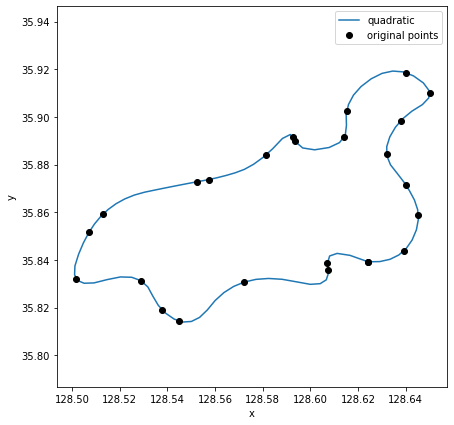

In [75]:
points = np.array([curve_x, curve_y]).T  # a (nbre_points x nbre_dim) array

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
#interpolations_methods = ['slinear', 'quadratic', 'cubic']
interpolations_methods = ['quadratic']
alpha = np.linspace(0, 1, 100)

interpolated_points = {}
for method in interpolations_methods:
    interpolator =  interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);

plt.plot(*points.T, 'ok', label='original points');
plt.axis('equal'); 
plt.legend(); 
plt.xlabel('x'); 
plt.ylabel('y');

In [76]:
map_result_curve_sub = folium.Map(location = [35.8649035,128.5823176], zoom_start = 12)

for i in range(len(curve) - 1):
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color="white", weight=9, opacity=1, offset = 0).add_to(map_result_curve_sub)
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color='#58FA82', weight=5, opacity=1, offset = 0).add_to(map_result_curve_sub)

for i in range(len(points)):
    folium.CircleMarker([points[i, 1], points[i, 0]], color="#000", fill_color="#ccc", fill_opacity=1, radius=5, weight=3, opacity=1).add_to(map_result_curve_sub)

# 카페 데이터 : 빨강
for i in range(len(last_y)):
    folium.CircleMarker([last_y[i], last_x[i]], color = '#red', radius = 3, fill_color= "red", fill_opacity = 1).add_to(map_result_curve_sub)

# 버스 데이터 : 보라
for i in range(len(bus_location_y)):
    if (i != 4): # 본동 제거
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 3, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_curve_sub)

# 사람적고 카페적음 : 파랑
for i in range(len(pldl_y)):
    folium.CircleMarker([pldl_y[i], pldl_x[i]], color = 'blue', radius = 3, fill_color= "blue", fill_opacity = 1).add_to(map_result_curve_sub)

# 사람많고 카페적음 : 시안
for i in range(len(pmdl_y)):
    folium.CircleMarker([pmdl_y[i], pmdl_x[i]], color = 'cyan', radius = 3, fill_color= "cyan", fill_opacity = 1).add_to(map_result_curve_sub)

map_result_curve_sub

In [77]:
map_result_curve_last = folium.Map(location = [35.8649035,128.5823176], zoom_start = 12)

sub1 = pd.read_pickle(route + "sub1.pkl")
sub2 = pd.read_pickle(route + "sub2.pkl")
sub3 = pd.read_pickle(route + "sub3.pkl")

sub1.sort_values(by=['long'], axis = 0)
sub2.sort_values(by=['long'], axis = 0)
sub3.sort_values(by=['lat'], axis = 0)

for i in range(0, len(sub1) - 1):
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color='#446AE8', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(sub1), len(sub1) + len(sub2) - 1):
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color='#F781D8', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)
    
for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3) - 1):
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color='#B43104', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(sub1)):
    folium.CircleMarker([sub1['lat'][i], sub1['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

for i in range(len(sub1), len(sub1)+len(sub2)):
    folium.CircleMarker([sub2['lat'][i], sub2['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3)):
    folium.CircleMarker([sub3['lat'][i], sub3['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

    
######################################################################################################################################################################################    
    

for i in range(len(curve) - 1):
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color="white", weight=10, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color='#101010', weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(points)):
    folium.CircleMarker([points[i, 1], points[i, 0]], color="#000", fill_color="#ccc", fill_opacity=1, radius=5, weight=3, opacity=1).add_to(map_result_curve_last)

# 카페 데이터 : 빨강
for i in range(len(last_y)):
    folium.CircleMarker([last_y[i], last_x[i]], color = '#red', radius = 3, fill_color= "red", fill_opacity = 1).add_to(map_result_curve_last)

# 버스 데이터 : 보라
for i in range(len(bus_location_y)):
    if (i != 4): # 본동 제거
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 3, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_curve_last)

# 사람적고 카페적음 : 파랑
for i in range(len(pldl_y)):
    folium.CircleMarker([pldl_y[i], pldl_x[i]], color = 'blue', radius = 3, fill_color= "blue", fill_opacity = 1).add_to(map_result_curve_last)

# 사람많고 카페적음 : 시안
for i in range(len(pmdl_y)):
    folium.CircleMarker([pmdl_y[i], pmdl_x[i]], color = 'cyan', radius = 3, fill_color= "cyan", fill_opacity = 1).add_to(map_result_curve_last)
        
map_result_curve_last.save('대구4호선지하철노선예상도.html')
map_result_curve_last


In [78]:
map_result_curve_last = folium.Map(location = [35.8649035,128.5823176], zoom_start = 12, tiles="Mapbox Bright")

sub1 = pd.read_pickle(route + "sub1.pkl")
sub2 = pd.read_pickle(route + "sub2.pkl")
sub3 = pd.read_pickle(route + "sub3.pkl")

sub1.sort_values(by=['long'], axis = 0)
sub2.sort_values(by=['long'], axis = 0)
sub3.sort_values(by=['lat'], axis = 0)

for i in range(0, len(sub1) - 1):
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub1['lat'][i], sub1['long'][i]], [sub1['lat'][i+1], sub1['long'][i+1]]], color='#446AE8', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(sub1), len(sub1) + len(sub2) - 1):
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub2['lat'][i], sub2['long'][i]], [sub2['lat'][i+1], sub2['long'][i+1]]], color='#F781D8', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)
    
for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3) - 1):
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color="white", weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[sub3['lat'][i], sub3['long'][i]], [sub3['lat'][i+1], sub3['long'][i+1]]], color='#B43104', weight=3, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(sub1)):
    folium.CircleMarker([sub1['lat'][i], sub1['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

for i in range(len(sub1), len(sub1)+len(sub2)):
    folium.CircleMarker([sub2['lat'][i], sub2['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

for i in range(len(sub1) + len(sub2), len(sub1) + len(sub2) + len(sub3)):
    folium.CircleMarker([sub3['lat'][i], sub3['long'][i]], color="#000", fill_color="#ccc", fill_opacity=1, radius=3, weight=1.5, opacity=1).add_to(map_result_curve_last)

    
######################################################################################################################################################################################    
    

for i in range(len(curve) - 1):
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color="white", weight=10, opacity=1, offset = 0).add_to(map_result_curve_last)
    folium.PolyLine([[curve[i, 1], curve[i, 0]], [curve[i+1, 1], curve[i+1, 0]]], color='#58FA82', weight=5, opacity=1, offset = 0).add_to(map_result_curve_last)

for i in range(len(points)):
    folium.CircleMarker([points[i, 1], points[i, 0]], color="#000", fill_color="#ccc", fill_opacity=1, radius=5, weight=3, opacity=1).add_to(map_result_curve_last)

# 카페 데이터 : 빨강
for i in range(len(last_y)):
    folium.CircleMarker([last_y[i], last_x[i]], color = '#red', radius = 3, fill_color= "red", fill_opacity = 1).add_to(map_result_curve_last)

# 버스 데이터 : 보라
for i in range(len(bus_location_y)):
    if (i != 4): # 본동 제거
        folium.CircleMarker([np.array(bus_location_y)[i], np.array(bus_location_x)[i]], color = '#7B1FCC', radius = 3, fill_color= "#7B1FCC", fill_opacity = 1).add_to(map_result_curve_last)

# 사람적고 카페적음 : 파랑
for i in range(len(pldl_y)):
    folium.CircleMarker([pldl_y[i], pldl_x[i]], color = 'blue', radius = 3, fill_color= "blue", fill_opacity = 1).add_to(map_result_curve_last)

# 사람많고 카페적음 : 시안
for i in range(len(pmdl_y)):
    folium.CircleMarker([pmdl_y[i], pmdl_x[i]], color = 'cyan', radius = 3, fill_color= "cyan", fill_opacity = 1).add_to(map_result_curve_last)
        
map_result_curve_last
map_result_curve_last.save('대구흑백.html')